In [1]:
import itertools
import jax
from jax import jit, vmap
import torch
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.95" 

In [3]:
torch.cuda.is_available()

True

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
key = jax.random.PRNGKey(2)

2024-06-07 17:38:23.673269: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
import equinox as eqx

In [7]:
from vae_jax import VAE

In [8]:
img_size = 256
batch_size = 16
latent_img_size = 32
z_dim = 256

In [9]:
vae, vae_states = eqx.nn.make_with_state(VAE)(img_size, latent_img_size, z_dim, key)
init_vae_params, vae_static = eqx.partition(vae, eqx.is_inexact_array)
# x = jnp.zeros((1, 3, 256, 256)) # we must have a batch_dim, the model can only be applied afetr vmap because of BN layer
# batch_model = jax.vmap(model, in_axes=(0, None, None, None), out_axes=(0, None), axis_name="batch")
# x, state = batch_model(x, state, key, True)

In [10]:
from utils import get_train_dataloader, get_test_dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader
from datasets import LivestockTrainDataset
train_dataset = LivestockTrainDataset(
    img_size,
    fake_dataset_size=50000,
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
@partial(jit, static_argnums=(1, 6))
def loss(params, beta, static, states, x, key, train=True):
    """
    Parameters
    ----------
    params
        XXX
    static
        XXX
    states
        XXX
    x
        A batch of inputs
    key
        A JAX PRNGKey
    """
    vae = eqx.combine(params, static)
    if train:
        # make sure we are in training mode
        vae = eqx.nn.inference_mode(vae, value=False)
    else:
        vae = eqx.nn.inference_mode(vae)
    batched_vae = vmap(vae, in_axes=(0, None, None, None), out_axes=(0,  None, 0, 0), axis_name="batch")

    key, subkey = jax.random.split(key, 2)

    x_rec, states, mu, logvar = batched_vae(x, states, key, train)
    batched_elbo = vmap(vae.elbo, in_axes=(0, 0, 0, 0, None), out_axes=(0, 0, 0))

    elbo, rec_term, kld = batched_elbo(x_rec, x, mu, logvar, beta)
    elbo = jnp.mean(elbo) # avg over the batches
    rec_term = jnp.mean(rec_term)
    kld = jnp.mean(kld)

    x_rec = VAE.mean_from_lambda(x_rec)

    return -elbo, (x_rec, rec_term, kld, states, mu, logvar)

Test the loss on one mini-batch

In [13]:
mini_batch = next(iter(train_dataloader))
loss_value, (_, _, _, vae_states, _, _) = loss(init_vae_params, 1., vae_static, vae_states, mini_batch[0].numpy(), key, train=True)

In [14]:
import copy
init_params = init_vae_params
init_states = vae_states
static = vae_static

In [15]:
vae = eqx.combine(init_params, static)

In [16]:
import optax

n_steps_inner = 30
n_steps_outer = 100

lr_inner = 1e-3
lr_outer = 1e-3

print_every = 1

init_beta = jnp.array(0.1)

optimizer_inner = optax.adam(lr_inner)
opt_state_inner = optimizer_inner.init(init_params)
optimizer_outer = optax.adam(lr_outer)
opt_state_outer = optimizer_outer.init(init_beta)

In [17]:
def train_inner(beta, params, static, states, train_data, opt_state, key, print_every):
    """
    must not necesarily be jittable since we a priori only need to get grad
    but we provide a jittable train_inner for speed
    """

    def make_step(carry, x):
        params, beta, states, opt_state, key = carry
        key, subkey = jax.random.split(key)
        (minus_elbo, aux_loss), grads = jax.value_and_grad(loss, argnums=0, has_aux=True)(params, beta, static, states, x, subkey, train=True)
        _, rec_term, kld, states, _, _ = aux_loss
        updates, opt_state = optimizer_inner.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, beta, states, opt_state, key), jnp.array([minus_elbo, rec_term, kld])

    carry_init = (
        params, beta, states, opt_state, key
    )
    carry, losses = jax.lax.scan(
        make_step,
        carry_init,
        train_data
    )
    params = carry[0]
    states = carry[2]
    opt_state = carry[3]
    return params, states, (losses[:, 0], losses[:, 1], losses[:, 2]), opt_state

In [ ]:
@partial(jax.custom_jvp, nondiff_argnums=(0, 2, 3, 4, 5)) # we will not differentiate wrt something else than beta
def train_inner_(beta, params, static, states, train_data, opt_state_inner, key):
    return train_inner(beta, params, static, states, train_data, opt_state_inner, key, print_every)
    
@train_inner_.defjvp
def train_inner_jvp(beta, static, states, opt_state_inner, key, primals, tangents):
    """
    Note that nondiff arg placed at the start of the signature of the corresponding JVP rule
    """
    params, = primals
    v, = tangents
    key, subkey = jax.random.split(key)
    # compute x_0(beta_0) (for a given beta_0). The gives the couple (x0, beta_0) around which we are authorized to use th IFT formula
    params_0_beta, _, (_, _, _), _ = train_inner_(
        beta, params, static, states, opt_state_inner, subkey
    )
    # subkeys not considered below since train=False
    Ax = lambda x:-jax.jacfwd(lambda params_:jax.grad(loss, argnums=0)(params_, beta, static, states, x, subkey, train=False))(params_0_beta) @ x
    b = jax.jacfwd(lambda beta_:jax.grad(loss, argnums=0)(params, beta_, static, states, x, subkey, train=False))(beta) # second diff wrt lambda

    return params_0_beta, jax.scipy.sparse.linalg.cg(matvec, b) * v

In [ ]:
def train_outer(n_steps_outer, n_steps_inner, params, beta, static, states, train_loader, opt_state_outer, opt_state_inner, key, print_every):
    """
    TODO change train_loader into validation_loader
    """
    def infinite_train_loader():
        while True:
            yield from train_loader

    def make_step(x, params, beta, states, opt_state_outer, opt_state_inner, key):
        key, subkey = jax.random.split(key)

        # this call to train_inner_ gives a x_0, theta_0 (the resulting couple (params, beta)
        # this couple is a root of F(=dELBO(params, beta)/dparams) (for a fixed theta_0 (beta)),
        # using a SGD that starts at a x_init (params)
        params, states, (elbo_list, rec_term_list, kld_list), opt_state_inner = train_inner_(
            beta, params, static, states, opt_state_inner, subkey
        )
        # ... around this x_0, theta_0 we know that we have the right to compute dx*(theta)/dtheta and we have done so
        # in the jvp defined in the previous cells
        # Now we want to compute the ELBO for the outer loss and take gradient wrt to theta here.
        # We have defined a rule to backpropagate through beta i.e.
        # through train_inner (dx*(theta)/dtheta) in the previous cells
        (minus_elbo, aux_loss), grads = jax.value_and_grad(loss, argnums=1, has_aux=True)(params, beta, static, states, x, subkey, train=False)
        x_rec, rec_term, kld, _, _, _ = aux_loss
        updates, opt_state_outer = optimizer_outer.update(grads, opt_state_outer, params)
        beta = optax.apply_updates(beta, updates)
        return params, beta, states, opt_state_outer, opt_state_inner, key, x_rec, (elbo_list, rec_term_list, kld_list)

    elbo_list = []
    rec_term_list = []
    kld_list = []
    beta_list = []


    for step, (x, _) in zip(range(n_steps), infinite_train_loader()): 
        x = x.numpy()
        inner_train_data = jnp.asarray(
            list(map(lambda x:x[0].numpy(), list(itertools.islice(train_loader, n_steps_inner)))) # get the next n_steps_inner elements from train_loader
        )
        params, beta, states, opt_state_outer, opt_state_inner, key, x_rec, losses = make_step(
            x, params, beta, states, inner_train_data, opt_state_outer, opt_state_inner, step, key
        )
        elbo_list.extend(-losses[0])
        rec_term_list.extend(losses[1])
        kld_list.extend(losses[2])
        # elbo_list.append(-losses[0])
        # rec_term_list.append(losses[1])
        # kld_list.append(losses[2])
        beta_list.append(jnp.full((n_steps_inner,), beta))
        
        if (step % print_every) == 0 or (step == n_steps - 1):
            print(
                f"{step=}, elbo_loss={elbo_list[-1]}, rec_term={rec_term_list[-1]}, kld_term={kld_list[-1]}, beta={beta_list[-1]}"
            )
            
    return params, beta, states, (elbo_list, rec_term_list, kld_list), opt_state

In [18]:
key, subkey = jax.random.split(key)
final_params, final_states, loss_lists, opt_state = train_outer(
    n_steps_outer, n_steps_inner, init_params, beta, static, init_states, train_dataloader, opt_state_outer, opt_state_inner, key, print_every
)

2024-06-06 10:32:44.962019: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 1.75GiB (1883173461 bytes) by rematerialization; only reduced to 1.90GiB (2042679589 bytes), down from 1.90GiB (2042679589 bytes) originally
E0606 10:32:47.926754   41169 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0606 10:32:48.066942   41169 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


step=0, elbo_loss=-0.04027123749256134, rec_term=0.005496364086866379, kld_term=0.4576759934425354, beta=0.10000000149011612


2024-06-06 10:33:00.864891: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 1.75GiB (1883173461 bytes) by rematerialization; only reduced to 1.90GiB (2042679589 bytes), down from 1.90GiB (2042679589 bytes) originally


step=1, elbo_loss=0.04871109873056412, rec_term=0.07226970791816711, kld_term=0.23558607697486877, beta=0.10000000149011612


2024-06-06 10:33:03.072958: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 1.75GiB (1883173461 bytes) by rematerialization; only reduced to 1.90GiB (2042679589 bytes), down from 1.90GiB (2042679589 bytes) originally


step=2, elbo_loss=0.12458063662052155, rec_term=0.13895589113235474, kld_term=0.14375251531600952, beta=0.10000000149011612
step=3, elbo_loss=0.17643965780735016, rec_term=0.18567624688148499, kld_term=0.09236589819192886, beta=0.10000000149011612
step=4, elbo_loss=0.24409325420856476, rec_term=0.24979335069656372, kld_term=0.05700097233057022, beta=0.10000000149011612
step=5, elbo_loss=0.29072606563568115, rec_term=0.29443031549453735, kld_term=0.03704269230365753, beta=0.10000000149011612
step=6, elbo_loss=0.3729151487350464, rec_term=0.3757667541503906, kld_term=0.028516113758087158, beta=0.10000000149011612
step=7, elbo_loss=0.43091142177581787, rec_term=0.43322089314460754, kld_term=0.023094696924090385, beta=0.10000000149011612
step=8, elbo_loss=0.4493681490421295, rec_term=0.451272189617157, kld_term=0.019040198996663094, beta=0.10000000149011612
step=9, elbo_loss=0.5181995034217834, rec_term=0.5199617147445679, kld_term=0.017622385174036026, beta=0.10000000149011612
step=10, el

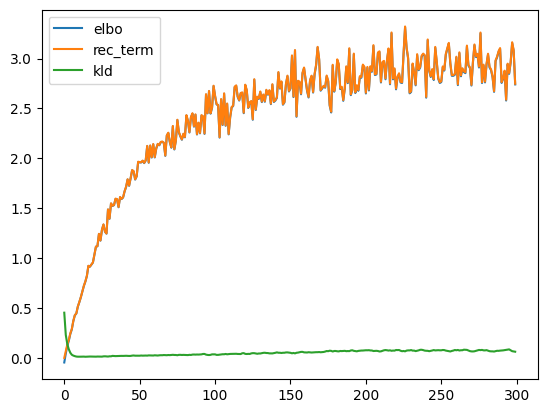

In [19]:
plt.plot(loss_lists[0], label="elbo")
plt.plot(loss_lists[1], label="rec_term")
plt.plot(loss_lists[2], label="kld")
plt.legend()
plt.show()

In [20]:
from datasets import LivestockTestDataset
test_dataset = LivestockTestDataset(
    img_size,
    fake_dataset_size=1024,
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
x_test = next(iter(test_dataloader))
x_test =  x_test[0].numpy()

In [22]:
key, subkey = jax.random.split(key)
(_, aux_loss) = loss(final_params, static, final_states, x_test, subkey, train=False, beta=beta)
x_rec_test = aux_loss[0]

vae_mu = aux_loss[-1]
mad = jnp.mean(jnp.abs(vae_mu - jnp.mean(vae_mu, axis=(1), keepdims=True)), axis=(1)) # mean on latent dims for all batches

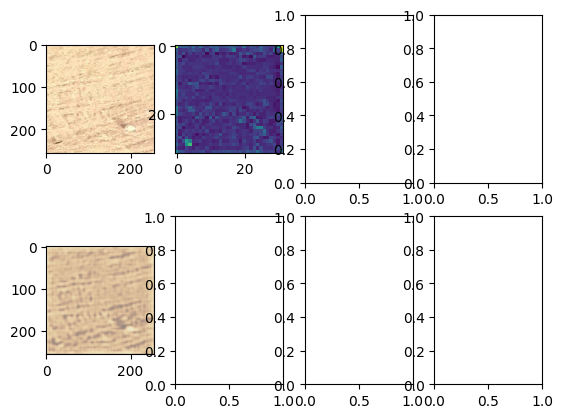

In [23]:
figure, axes = plt.subplots(2, 4)
axes[0, 0].imshow(jnp.moveaxis(x_test[1],0, 2))
axes[1, 0].imshow(jnp.moveaxis(x_rec_test[1], 0, 2))
axes[0, 1].imshow(mad[1])
plt.show()